## Load Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
##
import pandas as pd
import numpy as np
import dalex as dx
import math
import matplotlib.pyplot as plt
from pprint import pprint
##
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
##
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
##
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
##
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 
##
from sklearn.svm import NuSVC
from sklearn.svm import SVC
##
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

## Function

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = round(metrics.accuracy_score(y_true=test_labels, y_pred=predictions),2)
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, predictions)
    auc = round(metrics.auc(fpr,tpr),2)
    roc_auc = round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions),2)
    roc_auc_score = round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions),2)
    print(f"Accuracy = {accuracy}\n")
    print(f"AUC = {auc}\n")
    print(f"ROC AUC = {roc_auc}\n")
    print(f"ROC AUC SCORE = {roc_auc_score}\n")
    return(accuracy,auc,roc_auc,roc_auc_score)

In [3]:
def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    return important_features

## Load Data

In [4]:
data_bondora = pd.read_csv('data_bondora.csv',low_memory=False)
data_bondora.drop('loanid', inplace=True, axis=1)

## Data Info

In [5]:
data_bondora.info()
data_bondora.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116695 entries, 0 to 116694
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   bidsmanual                         116695 non-null  float64
 1   newcreditcustomer                  116695 non-null  bool   
 2   verificationtype                   116695 non-null  int64  
 3   languagecode                       116695 non-null  int64  
 4   age                                116695 non-null  int64  
 5   gender                             116695 non-null  int64  
 6   country                            116695 non-null  int64  
 7   appliedamount                      116695 non-null  float64
 8   amount                             116695 non-null  float64
 9   interest                           116695 non-null  float64
 10  loanduration                       116695 non-null  int64  
 11  monthlypayment                     1166

,bidsmanual,newcreditcustomer,verificationtype,languagecode,age,gender,country,appliedamount,amount,interest,...,principalpaymentsmade,interestandpenaltypaymentsmade,principalbalance,interestandpenaltybalance,noofpreviousloansbeforeloan,default,diffloanappdate,loandate_year,maturitydate_year,income_type_sum
0,2390.0,False,3,1,23,0,2,5500.0,5500.0,44.65,...,5500.00,3049.61,0.00,0.0,1,0,4,2015,2020,1
1,0.0,False,3,0,25,0,2,1200.0,1200.0,23.83,...,1200.00,337.29,0.00,0.0,1,0,0,2015,2020,1
2,1000.0,True,2,1,22,1,2,1000.0,1000.0,75.19,...,1000.00,272.99,0.00,0.0,0,1,0,2015,2020,3
3,645.0,True,1,0,28,0,1,2000.0,2000.0,24.46,...,1387.57,1845.64,612.43,0.0,0,0,4,2015,2020,1
4,0.0,True,2,0,49,1,1,1000.0,1000.0,21.76,...,1000.00,462.42,0.00,0.0,0,0,5,2015,2020,2


In [6]:
data_bondora.isnull().sum()

bidsmanual                           0
newcreditcustomer                    0
verificationtype                     0
languagecode                         0
age                                  0
gender                               0
country                              0
appliedamount                        0
amount                               0
interest                             0
loanduration                         0
monthlypayment                       0
education                            0
employmentdurationcurrentemployer    0
homeownershiptype                    0
incomefromprincipalemployer          0
incomefrompension                    0
incomefromfamilyallowance            0
incomefromsocialwelfare              0
incomefromleavepay                   0
incomefromchildsupport               0
incomeother                          0
incometotal                          0
existingliabilities                  0
liabilitiestotal                     0
monthlypaymentday        

In [7]:
data_bondora = data_bondora.dropna()
data_bondora.isnull().sum()

bidsmanual                           0
newcreditcustomer                    0
verificationtype                     0
languagecode                         0
age                                  0
gender                               0
country                              0
appliedamount                        0
amount                               0
interest                             0
loanduration                         0
monthlypayment                       0
education                            0
employmentdurationcurrentemployer    0
homeownershiptype                    0
incomefromprincipalemployer          0
incomefrompension                    0
incomefromfamilyallowance            0
incomefromsocialwelfare              0
incomefromleavepay                   0
incomefromchildsupport               0
incomeother                          0
incometotal                          0
existingliabilities                  0
liabilitiestotal                     0
monthlypaymentday        

In [8]:
data_bondora['default'].value_counts()

0    80737
1    35958
Name: default, dtype: int64

In [9]:
print("%.2f" % round(34703/len(data_bondora.index), 2))

0.30


## Graph

## Split Data

In [10]:
X = data_bondora.drop('default', axis=1)
y = data_bondora.default
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Correlation

In [11]:
corr = X.corr()
corr

,bidsmanual,newcreditcustomer,verificationtype,languagecode,age,gender,country,appliedamount,amount,interest,...,restructured,principalpaymentsmade,interestandpenaltypaymentsmade,principalbalance,interestandpenaltybalance,noofpreviousloansbeforeloan,diffloanappdate,loandate_year,maturitydate_year,income_type_sum
bidsmanual,1.000000,0.059018,-0.006536,0.040979,0.019912,-0.091062,0.086785,0.352103,0.380573,-0.060688,...,0.075106,0.258933,0.283400,0.228002,0.141177,-0.045414,0.148611,-0.072342,-0.126877,0.007499
newcreditcustomer,0.059018,1.000000,0.125352,-0.290813,-0.023051,0.203299,-0.294675,0.148443,0.149055,0.357280,...,-0.129328,0.058766,0.122837,0.118216,0.135167,-0.841229,0.152660,-0.077368,0.006323,0.081443
verificationtype,-0.006536,0.125352,1.000000,-0.139675,0.011030,0.088964,-0.160678,0.027751,0.061665,0.145496,...,-0.086398,-0.048646,-0.022494,0.101258,-0.066993,-0.090239,-0.242407,0.301412,0.263653,-0.263703
languagecode,0.040979,-0.290813,-0.139675,1.000000,-0.162730,-0.205624,0.742745,-0.124616,-0.110589,-0.470960,...,0.080722,0.027999,-0.045311,-0.138541,-0.122225,0.269984,-0.118707,-0.015733,-0.064232,0.037724
age,0.019912,-0.023051,0.011030,-0.162730,1.000000,0.016972,-0.106233,0.056434,0.066720,-0.046136,...,-0.029275,-0.029368,0.022403,0.093044,-0.049723,0.039306,-0.042502,0.126660,0.099223,-0.118219
gender,-0.091062,0.203299,0.088964,-0.205624,0.016972,1.000000,-0.350150,-0.002337,-0.004923,0.259610,...,-0.080257,-0.045682,-0.020007,0.025307,0.041389,-0.215071,0.034686,0.014038,0.055753,0.142069
country,0.086785,-0.294675,-0.160678,0.742745,-0.106233,-0.350150,1.000000,-0.043962,-0.013721,-0.642133,...,0.119759,0.071447,-0.000671,-0.063579,-0.168441,0.285545,-0.179452,0.028857,-0.018584,0.014802
appliedamount,0.352103,0.148443,0.027751,-0.124616,0.056434,-0.002337,-0.043962,1.000000,0.917581,-0.001929,...,0.037892,0.409227,0.486013,0.702615,0.203347,-0.114124,0.141553,-0.029601,0.113534,0.083921
amount,0.380573,0.149055,0.061665,-0.110589,0.066720,-0.004923,-0.013721,0.917581,1.000000,-0.026751,...,0.035813,0.427546,0.507729,0.779019,0.192771,-0.105692,0.070681,0.034814,0.158955,0.034422
interest,-0.060688,0.357280,0.145496,-0.470960,-0.046136,0.259610,-0.642133,-0.001929,-0.026751,1.000000,...,-0.112127,-0.061850,0.065421,0.013116,0.162893,-0.346249,0.026072,-0.008610,0.012917,-0.017389


In [12]:
features_corr = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.3).any() # 0.3 lub 0.4
features_corr

bidsmanual                           False
newcreditcustomer                    False
verificationtype                     False
languagecode                         False
age                                   True
gender                               False
country                              False
appliedamount                        False
amount                               False
interest                             False
loanduration                         False
monthlypayment                       False
education                             True
employmentdurationcurrentemployer     True
homeownershiptype                     True
incomefromprincipalemployer          False
incomefrompension                    False
incomefromfamilyallowance            False
incomefromsocialwelfare              False
incomefromleavepay                    True
incomefromchildsupport               False
incomeother                          False
incometotal                           True
existinglia

In [13]:
X_good = corr.loc[features_corr, features_corr]
lst_variable_corr = X_good.columns.values.tolist()
X_corr = X[np.intersect1d(X.columns, lst_variable_corr)]

In [14]:
df_corr = X[X_corr.columns]

In [15]:
df_corr

,age,education,employmentdurationcurrentemployer,homeownershiptype,incomefromleavepay,incometotal,liabilitiestotal,monthlypaymentday,restructured
0,23,4,3,4,0,650.0,718.99,15,0
1,25,2,3,2,0,445.0,386.77,13,0
2,22,0,3,2,1,1117.0,335.00,20,0
3,28,3,4,1,0,2097.0,629.00,15,1
4,49,0,8,4,0,1472.0,803.00,5,0
...,...,...,...,...,...,...,...,...,...
116690,37,2,8,5,0,1400.0,500.00,1,0
116691,35,2,8,1,0,2265.0,1777.46,7,0
116692,40,2,8,1,0,2500.0,1350.00,1,0
116693,47,3,8,4,0,540.0,732.05,1,1


## RFE
    - https://heartbeat.fritz.ai/feature-ranking-with-recursive-feature-elimination-3e22db639208

In [16]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
model = DecisionTreeClassifier()
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=243153)
n_scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9569968182291942

In [17]:
pipe.fit(X, y)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=10)),
                ('Model', DecisionTreeClassifier())])

In [18]:
rfe.support_

array([False, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False,  True,  True,  True,  True, False, False,
        True, False, False])

In [19]:
X_rfe = pd.DataFrame(rfe.support_,X.columns,columns=['Rank'])
X_rfe = X_rfe[X_rfe.Rank==True]

In [20]:
df_rfe = X[X_rfe.index]

## Split Dataset 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_rfe, y, test_size=0.3)

## Gradient Boosting Classifier

In [22]:
clf_gbm = GradientBoostingClassifier()
clf_gbm.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(clf_gbm.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [23]:
gbm_params = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
}
pprint(gbm_params)

{'criterion': ['friedman_mse', 'mae'],
 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
 'max_depth': [3, 5, 8],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
 'min_samples_split': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
 'n_estimators': [10],
 'subsample': [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]}


In [24]:
random_gbm = RandomizedSearchCV(estimator = clf_gbm, 
                                param_distributions = gbm_params, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
random_gbm.fit(X_train,y_train)
random_gbm.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'subsample': 0.85,
 'n_estimators': 10,
 'min_samples_split': 0.2090909090909091,
 'min_samples_leaf': 0.17272727272727273,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [25]:
exp_gbm_clf = dx.Explainer(clf_gbm, X_train, y_train)
exp_gbm_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fdf6944f550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000986, mean = 0.306, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.964, mean = -3.56e-05, max = 0.998
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
GradientBoostingClassifier,0.895284,0.978209,0.934911,0.961817,0.990503


In [26]:
exp_gbm_clf = dx.Explainer(random_gbm, X_train, y_train)
exp_gbm_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.model_selection._search.RandomizedSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fdf6944f550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0581, mean = 0.309, max = 0.804
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.804, mean = -0.0032, max = 0.934
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomizedSearchCV,0.802398,0.907103,0.851544,0.914306,0.970729


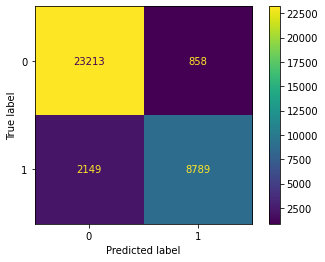

In [27]:
plot_confusion_matrix(random_gbm, X_test, y_test) 
plt.show()  

## Logistic Regression

In [28]:
clf_logit = LogisticRegression(random_state=0)
clf_logit.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(clf_logit.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [29]:
logit_params = {
     'C': [1.0],
     'class_weight': [None],
     'dual': [False], 
     'fit_intercept': [True,False],
     'intercept_scaling': [1],
     'l1_ratio': [0.1,0.5,0.7],
     'max_iter': [50,100,150,200,250], 
     'penalty': ['l2','elasticnet'],
     'random_state': [0],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'tol': [0.0001],
     'verbose': [0],
     'warm_start': [True,False],  
     'n_jobs': [-1]
}
pprint(logit_params)

{'C': [1.0],
 'class_weight': [None],
 'dual': [False],
 'fit_intercept': [True, False],
 'intercept_scaling': [1],
 'l1_ratio': [0.1, 0.5, 0.7],
 'max_iter': [50, 100, 150, 200, 250],
 'n_jobs': [-1],
 'penalty': ['l2', 'elasticnet'],
 'random_state': [0],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'tol': [0.0001],
 'verbose': [0],
 'warm_start': [True, False]}


In [30]:
random_logit = RandomizedSearchCV(estimator = clf_logit, 
                                  param_distributions = logit_params, 
                                  n_iter = 100, 
                                  cv = 5, 
                                  verbose=2, 
                                  random_state=42, 
                                  n_jobs = -1)
random_logit.fit(X_train,y_train)
random_logit.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'warm_start': False,
 'verbose': 0,
 'tol': 0.0001,
 'solver': 'newton-cg',
 'random_state': 0,
 'penalty': 'l2',
 'n_jobs': -1,
 'max_iter': 250,
 'l1_ratio': 0.5,
 'intercept_scaling': 1,
 'fit_intercept': True,
 'dual': False,
 'class_weight': None,
 'C': 1.0}

In [31]:
exp_logit_clf = dx.Explainer(clf_logit, X_train, y_train)
exp_logit_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fdf6944f550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.43e-11, mean = 0.306, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 1.82e-05, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
LogisticRegression,0.853078,0.977245,0.910949,0.948914,0.979414


In [32]:
exp_logit_clf = dx.Explainer(random_logit, X_train, y_train)
exp_logit_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.model_selection._search.RandomizedSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fdf6944f550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.74e-10, mean = 0.306, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 8.55e-08, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomizedSearchCV,0.852958,0.977779,0.911113,0.949024,0.980918


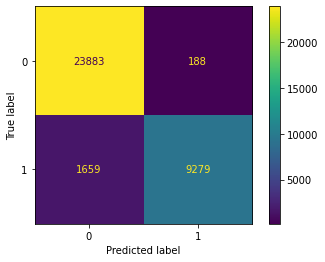

In [33]:
plot_confusion_matrix(random_logit, X_test, y_test) 
plt.show()  

## SGD Classifier

In [34]:
clf_sgd = SGDClassifier()
clf_sgd.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(clf_sgd.get_params())

Parameters currently in use:

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [35]:
sgd_params = {
    'alpha': [0.0001],
    'average': [True,False],
    'class_weight': [None],
    'early_stopping': [True,False],
    'epsilon': [0.1],
    'eta0': [0.1],
    'fit_intercept': [True,False],
    'l1_ratio': [0.1,0.2,0.3],
    'learning_rate': ['constant','optimal','invscaling'],
    'loss': ['hinge','log','modified_huber','squared_hinge','perceptron'],
    'max_iter': [100,500,1000,10000],
    'n_iter_no_change': [5],
    'n_jobs': [-1],
    'penalty': ['l2','l1','elasticnet'],
    'power_t': [0.5,0.7,0.9],
    'random_state': [None],
    'shuffle': [True,False],
    'tol': [0.001],
    'validation_fraction': [0.1],
    'verbose': [0],
    'warm_start': [True,False]
}
pprint(sgd_params)

{'alpha': [0.0001],
 'average': [True, False],
 'class_weight': [None],
 'early_stopping': [True, False],
 'epsilon': [0.1],
 'eta0': [0.1],
 'fit_intercept': [True, False],
 'l1_ratio': [0.1, 0.2, 0.3],
 'learning_rate': ['constant', 'optimal', 'invscaling'],
 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
 'max_iter': [100, 500, 1000, 10000],
 'n_iter_no_change': [5],
 'n_jobs': [-1],
 'penalty': ['l2', 'l1', 'elasticnet'],
 'power_t': [0.5, 0.7, 0.9],
 'random_state': [None],
 'shuffle': [True, False],
 'tol': [0.001],
 'validation_fraction': [0.1],
 'verbose': [0],
 'warm_start': [True, False]}


In [36]:
random_sgd = RandomizedSearchCV(estimator = clf_sgd, 
                                param_distributions = sgd_params, 
                                n_iter = 100, 
                                cv = 5, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
random_sgd.fit(X_train,y_train)
random_sgd.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'warm_start': True,
 'verbose': 0,
 'validation_fraction': 0.1,
 'tol': 0.001,
 'shuffle': False,
 'random_state': None,
 'power_t': 0.7,
 'penalty': 'l1',
 'n_jobs': -1,
 'n_iter_no_change': 5,
 'max_iter': 10000,
 'loss': 'perceptron',
 'learning_rate': 'invscaling',
 'l1_ratio': 0.2,
 'fit_intercept': True,
 'eta0': 0.1,
 'epsilon': 0.1,
 'early_stopping': False,
 'class_weight': None,
 'average': True,
 'alpha': 0.0001}

In [37]:
exp_sgd_clf = dx.Explainer(clf_sgd, X_train, y_train)
exp_sgd_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.linear_model._stochastic_gradient.SGDClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.276, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.03, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
SGDClassifier,0.883014,0.978996,0.928531,0.958365,0.937286


In [38]:
exp_sgd_random = dx.Explainer(random_sgd, X_train, y_train)
exp_sgd_random.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.model_selection._search.RandomizedSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.287, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0195, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomizedSearchCV,0.910112,0.97204,0.940057,0.964449,0.949146


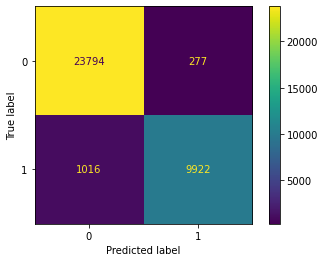

In [39]:
plot_confusion_matrix(random_sgd, X_test, y_test) 
plt.show()  

## Perceptron

In [40]:
clf_perceptron = Perceptron()
clf_perceptron.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(clf_perceptron.get_params())

Parameters currently in use:

{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [41]:
perceptron_params = {
    'alpha': [0.0001],
    'early_stopping': [True,False],
    'eta0': [0.5,0.7],
    'fit_intercept': [True,False],
    'max_iter': [100,500],
    'n_jobs': [-1],
    'penalty': ['l2','l1','elasticnet'],
    'random_state': [0],
    'shuffle': [True,False],
    'tol': [0.001],
    'validation_fraction':[0.1],
    'verbose': [0],
    'warm_start': [True,False]
}
pprint(perceptron_params)

{'alpha': [0.0001],
 'early_stopping': [True, False],
 'eta0': [0.5, 0.7],
 'fit_intercept': [True, False],
 'max_iter': [100, 500],
 'n_jobs': [-1],
 'penalty': ['l2', 'l1', 'elasticnet'],
 'random_state': [0],
 'shuffle': [True, False],
 'tol': [0.001],
 'validation_fraction': [0.1],
 'verbose': [0],
 'warm_start': [True, False]}


In [42]:
random_perceptron = RandomizedSearchCV(estimator = clf_perceptron, 
                                       param_distributions = perceptron_params, 
                                       n_iter = 100, 
                                       cv = 5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
random_perceptron.fit(X_train,y_train)
random_perceptron.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'warm_start': True,
 'verbose': 0,
 'validation_fraction': 0.1,
 'tol': 0.001,
 'shuffle': True,
 'random_state': 0,
 'penalty': 'l1',
 'n_jobs': -1,
 'max_iter': 100,
 'fit_intercept': False,
 'eta0': 0.7,
 'early_stopping': True,
 'alpha': 0.0001}

In [43]:
exp_perceptron_clf = dx.Explainer(clf_perceptron, X_train, y_train)
exp_perceptron_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.linear_model._perceptron.Perceptron (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.269, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0369, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
Perceptron,0.86311,0.98119,0.91837,0.953003,0.927449


In [44]:
exp_perceptron_random = dx.Explainer(random_perceptron, X_train, y_train)
exp_perceptron_random.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.model_selection._search.RandomizedSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.364, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.0582, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomizedSearchCV,0.931095,0.782454,0.850328,0.899603,0.9091


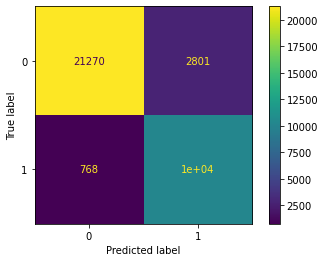

In [45]:
plot_confusion_matrix(random_perceptron, X_test, y_test) 
plt.show()  

## Passive Aggressive Classifier

In [46]:
clf_passive_aggressive = PassiveAggressiveClassifier()
clf_passive_aggressive.fit(X_train, y_train)
print('Parameters currently in use:\n')
pprint(clf_passive_aggressive.get_params())

Parameters currently in use:

{'C': 1.0,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'fit_intercept': True,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [47]:
passive_aggressive_params = {
    'C': [0.5,0.7,1.0,2.0],
    'average': [True,False],
    'class_weight': ['dict','balanced',None],
    'early_stopping': [True,False],
    'fit_intercept': [True,False],
    'loss': ['hinge','squared_hinge'],
    'max_iter': [100,250,500,1000,10000],
    'n_iter_no_change': [5,10,15,20],
    'n_jobs': [-1],
    'random_state': [42],
    'shuffle': [True,False],
    'tol': [0.001],
    'validation_fraction': [0.1,0.5,0.7],
    'verbose': [0],
    'warm_start': [True,False]
}
pprint(passive_aggressive_params)

{'C': [0.5, 0.7, 1.0, 2.0],
 'average': [True, False],
 'class_weight': ['dict', 'balanced', None],
 'early_stopping': [True, False],
 'fit_intercept': [True, False],
 'loss': ['hinge', 'squared_hinge'],
 'max_iter': [100, 250, 500, 1000, 10000],
 'n_iter_no_change': [5, 10, 15, 20],
 'n_jobs': [-1],
 'random_state': [42],
 'shuffle': [True, False],
 'tol': [0.001],
 'validation_fraction': [0.1, 0.5, 0.7],
 'verbose': [0],
 'warm_start': [True, False]}


In [48]:
random_passive_aggressive = RandomizedSearchCV(estimator = clf_passive_aggressive, 
                                               param_distributions = passive_aggressive_params, 
                                               n_iter = 100, 
                                               cv = 5, 
                                               verbose=2, 
                                               random_state=42, 
                                               n_jobs = -1)
random_passive_aggressive.fit(X_train,y_train)
random_passive_aggressive.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'warm_start': True,
 'verbose': 0,
 'validation_fraction': 0.7,
 'tol': 0.001,
 'shuffle': False,
 'random_state': 42,
 'n_jobs': -1,
 'n_iter_no_change': 20,
 'max_iter': 10000,
 'loss': 'hinge',
 'fit_intercept': False,
 'early_stopping': False,
 'class_weight': 'balanced',
 'average': True,
 'C': 2.0}

In [49]:
exp_passive_aggressive_clf = dx.Explainer(clf_passive_aggressive, X_train, y_train)
exp_passive_aggressive_clf.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.284, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0221, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
PassiveAggressiveClassifier,0.892766,0.962138,0.926155,0.956394,0.938438


In [50]:
exp_passive_aggressive_random = dx.Explainer(random_passive_aggressive, X_train, y_train)
exp_passive_aggressive_random.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 81686 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 81686 values
  -> model_class       : sklearn.model_selection._search.RandomizedSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fdf6944f4c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.288, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0187, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomizedSearchCV,0.90016,0.958546,0.928436,0.957496,0.941154


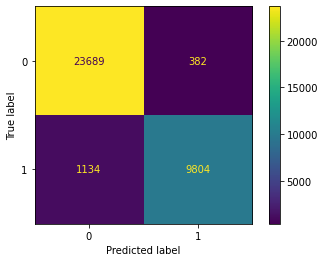

In [51]:
plot_confusion_matrix(random_passive_aggressive, X_test, y_test) 
plt.show()  